In [7]:
from pytorch_grad_cam import GradCAM
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from data_augmentation import *

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# 1. Get all the classes and the all the paths to images in dataset
classes = []
image_paths = []

for data_path in glob.glob('dataset' + '/*'):
    classes.append(data_path.split('/')[-1])
    image_paths.append(glob.glob(data_path + '/*'))

image_paths = list(itertools.chain.from_iterable(image_paths))
random.shuffle(image_paths)

print('Image Path: ', image_paths[0])
print('Class example: ', classes[0])

# 2. Split the dataset into train and test (80:20)
train_image_paths, test_image_paths = image_paths[:int(0.8*len(image_paths))], image_paths[int(0.8*len(image_paths)):] 

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}



NO_AUGMENTATION = 0
TO_GRAY = 1
TO_BLURRED = 2
TO_OUTLINES = 3
TO_SKETCH = 4

class GameCharacterDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentation=NO_AUGMENTATION):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image_file_path = self.image_paths[idx]
        image = cv2.imread(image_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)

        label = image_file_path.split('/')[-2]
        label = class_to_idx[label]

        if self.augmentation == TO_GRAY:
            image = to_gray(image)
        elif self.augmentation == TO_BLURRED:
            image = to_blurred(image)
        elif self.augmentation == TO_OUTLINES:
            image = to_outlines(image)
        elif self.augmentation == TO_SKETCH:
            image = to_sketch(image)

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

    def __len__(self):
        return len(image_paths)



train_dataset = GameCharacterDataset(train_image_paths, train_transforms)
test_dataset = GameCharacterDataset(test_image_paths, test_transforms)

Image Path:  dataset/ryu/ryu_30.png
Class example:  mario


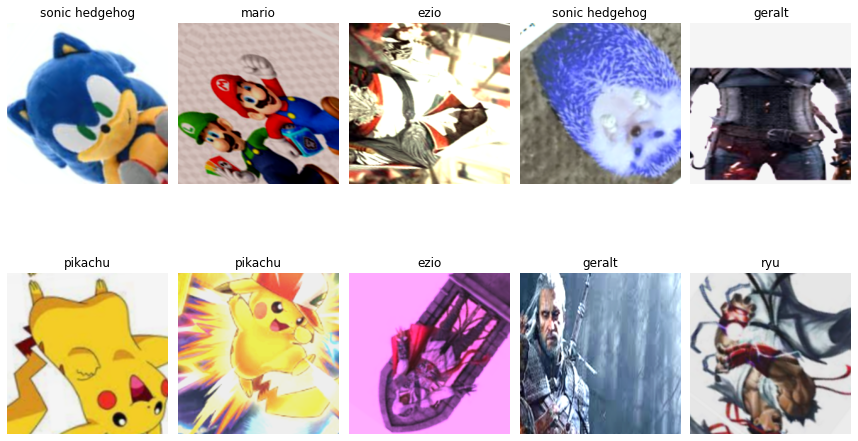

In [8]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Training Loop
epochs = 10

